In [2]:
from model_explainer import ClusteringExplainer
from sklearn.datasets import make_blobs
from utils.plots import plot_2D
import matplotlib.pyplot as plt
from itertools import product, combinations
from XQuerier import XQuerier
from cycler import cycler
import matplotlib as mpl
import pandas as pd
import numpy as np

### Variables à considérer:
- Nombre de features :
  - `Est-ce que le nombre de feature impacte la qualité des explications ?`
- Nombre de classes :
  - `Est-ce que le fait que les classes soient imbalanced (pour les cas 1vsAll et 2vsAll) influent (beaucoup) ?`
  - `Peut-être préferer le cas 1vs1 ou même les cas All ?`
- ~~Nombre de données~~
- Séparable (en 2D) ou pas

### Tester sur :
Les modèles supervisés :
- RBF SVM
- Decision Tree (modèle trop simple)
- KNN

Les modèles de XAI :
- LIME
- SHAP

## Génération des blobs

### Blob 
`blob_20`: $(N = 200, D = 2)$  $\lvert C \rvert = 20$

In [3]:
blob_20 = make_blobs(n_samples=500, n_features=7,centers=20, cluster_std=1.0, shuffle=True, random_state=1, return_centers=True)
X_20, y_20 = blob_20[0], blob_20[1]

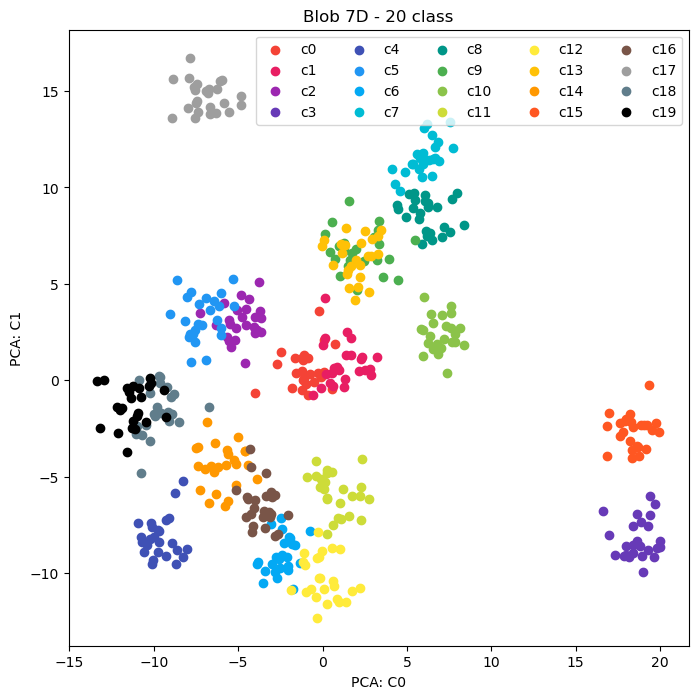

In [4]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#f44336', '#e81e63', '#9c27b0', '#673ab7', '#3f51b5',
                                                '#2196f3', '#03a9f4', '#00bcd4', '#009688', '#4caf50',
                                                '#8bc34a', '#cddc39', '#ffeb3b', '#ffc107', '#ff9800',
                                                '#ff5722', '#795548', '#9e9e9e', '#607d8b', '#000000' ])

# # two clusters of interests
# cl1, cl2 = 1, 7
# mask = (y_20 == cl1) + (y_20 == cl2)

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_2D(X_20, y_20, axs, pca_t = True, n_components=2, c1=0, c2=1, title="Blob 7D - 20 class")
axs.legend(ncol=5)
fig.savefig("./results/explain-it_test_blobs/Blob7D.png")

# 15 ET 4 TESTEEEERRR

#### 1vsALL

size c1: 25 | size c2: 25
Model: rbf_svm | xai: shap | th: 0.5 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (micro): 1.0000000000
------------------------------



Model: rbf_svm | xai: lime | th: 0.5 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (micro): 1.0000000000
------------------------------



Model: decision_tree | xai: shap | th: 0.5 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 0.9279279279
         (micro): 0.9800000000
------------------------------



Model: decision_tree | xai: lime | th: 0.5 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 0.9475478626
         (micro): 0.9850000000
------------------------------



Model: knn-uniform | xai: shap | th: 0.5 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
        

Exact explainer: 3it [31:51, 955.53s/it]              


Model: knn-uniform | xai: lime | th: 0.9 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (micro): 1.0000000000
------------------------------



Model: knn-dist | xai: shap | th: 0.9 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (micro): 1.0000000000
------------------------------



Model: knn-dist | xai: lime | th: 0.9 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (micro): 1.0000000000
------------------------------



Model: rbf_svm | xai: shap | th: 0.95 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (micro): 1.0000000000
------------------------------



Model: rbf_svm | xai: lime | th: 0.95 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (micro): 1.0000000000
-----------

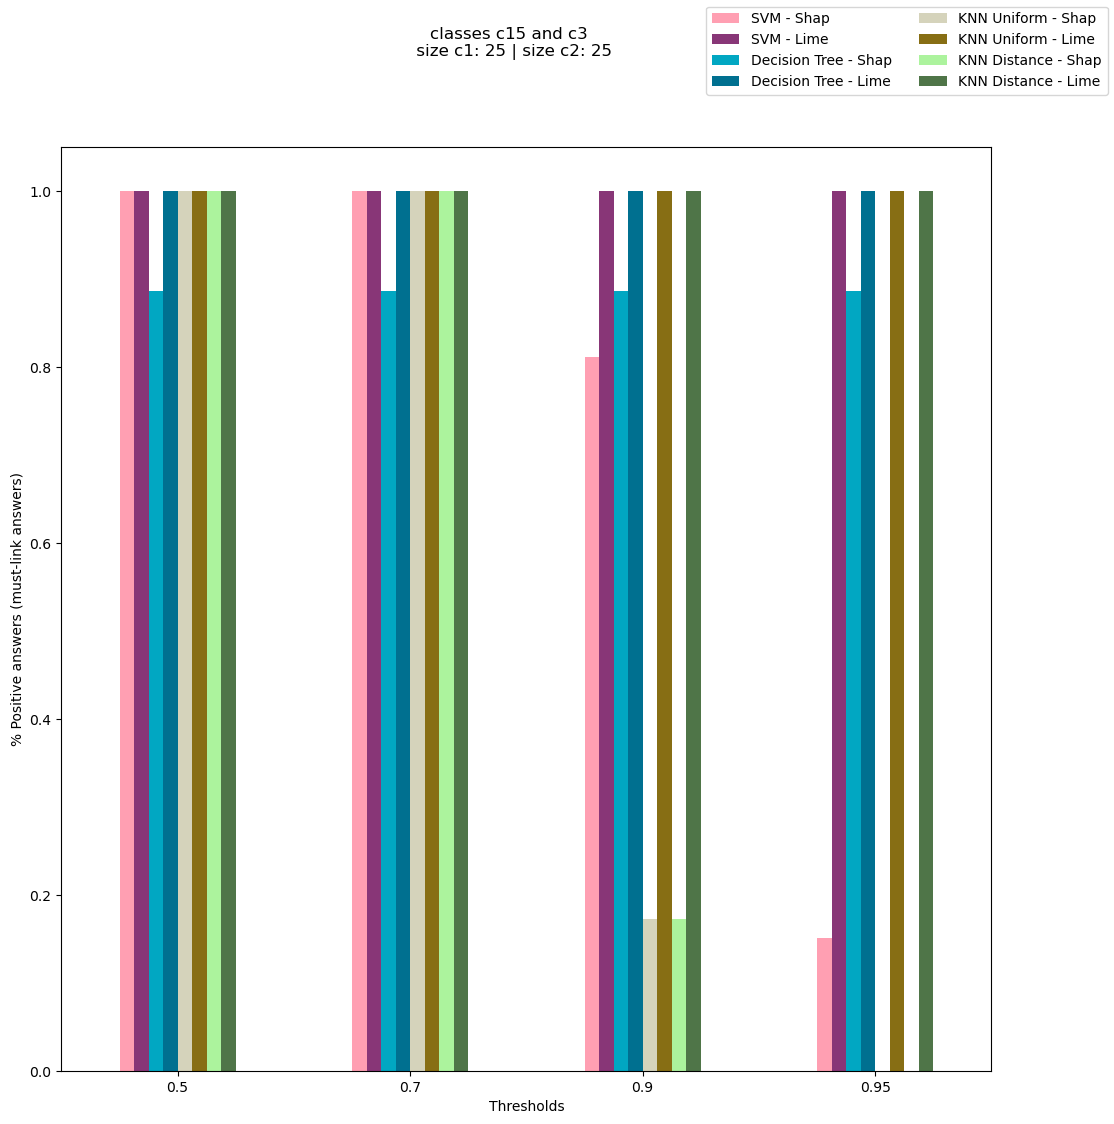

In [5]:
# Pour tous threshold
## Pour tout modèle
### Pour Lime/Shap
#### learn + explique
#### xquerier + save answer

# 1vsALL
# two clusters of interests
# cl1, cl2 = 11, 15


for (cl1, cl2) in [(15,3)]:
    mask_1vsAll = (y_20 == cl1) + (y_20 == cl2)
    y_20_1vA = y_20.copy()
    y_20_1vA[mask_1vsAll] = 1  # class of interest
    y_20_1vA[~mask_1vsAll] = 0 # all the others

    # we should have cannot-links only here
    mask_Cl1 = (y_20 == cl1)
    mask_Cl2 = (y_20 == cl2)

    idx_X_20 = np.arange(X_20.shape[0])
    idx_cl1, idx_cl2 = idx_X_20[mask_Cl1], idx_X_20[mask_Cl2]
    print(f"size c1: {idx_cl1.shape[0]} | size c2: {idx_cl2.shape[0]}")


    thresholds = [0.5, 0.7, 0.9, 0.95]
    models = ['rbf_svm', 'decision_tree', 'knn-uniform', 'knn-dist']
    xai_models = ['shap',
                   'lime']

    results = np.zeros(
        (len(models),
        len(thresholds),
        len(xai_models))
    )

    for idx_th, th in enumerate(thresholds):
        for idx_model, model in enumerate(models):
            for idx_xm, xm in enumerate(xai_models):
                xq = XQuerier(labels=None, xai_method=xm, strat="cosine_similarity", threshold=th)
                print(f"Model: {model} | xai: {xm} | th: {str(th)} fit...\n")
                model_explainer = ClusteringExplainer(model=model, xai_model=xm, verbose=True)
                model_explainer.fit(X_20, y_20_1vA)
                print("\n")
                for (x1, x2) in list(product(idx_cl1, idx_cl2)):
                    # generate explanations
                    explanations = model_explainer.explain(X_20[ [x1, x2] ], class_names=list(set(y_20_1vA)))
                    if xq.query_points(idx1=x1,  idx2=x2, exp1 = explanations[0], exp2 = explanations[1]):
                        results[idx_model][idx_th][idx_xm] += 1
    # results/=len(list(product(idx_cl1, idx_cl2)))
    print(results)

    results/=len(list(product(idx_cl1, idx_cl2)))
    colors_3_models =  [
        '#FF9FB2', #orange
        '#883677', #brown
        '#01A7C2', #blue
        '#007090', #dark-blue
        '#D5D3BB', #lemon
        '#876E14', #dark lemon
        '#ACF39D', #lightgreen
        '#4F7548', #dark-green, 
    ]

    mpl.rcParams['axes.prop_cycle'] = cycler(color=colors_3_models)
    df = pd.DataFrame({
            'SVM - Shap': results[0][:, 0], 'SVM - Lime': results[0][:, 1],
            'Decision Tree - Shap': results[1][:, 0], 'Decision Tree - Lime': results[1][:, 1],
            'KNN Uniform - Shap': results[2][:, 0], 'KNN Uniform - Lime': results[2][:, 1],
            'KNN Distance - Shap': results[3][:, 0], 'KNN Distance - Lime': results[3][:, 1],
        }, 
        index=thresholds
    )

    f, ax = plt.subplots(1, 1, figsize=(12, 12))
    df.plot.bar(rot=0, ax=ax, legend=None)
    ax.set_xlabel("Thresholds")
    ax.set_ylabel("% Positive answers (must-link answers)")
    f.suptitle(f"classes c{cl1} and c{cl2} \n size c1: {idx_cl1.shape[0]} | size c2: {idx_cl2.shape[0]}")
    # ax.legend(ncol=2)
    f.legend(ncol=2)
    f.savefig("./results/explain-it_test_blobs/10D_blob_1vsAll_lin_nonSep_"+str(cl1)+", "+str(cl2)+".png")

In [4]:
thresholds = [0.5, 0.7, 0.9, 0.95]
models = ['rbf_svm', 'decision_tree']#, 'knn']
xai_models = ['shap', 'lime']

results = np.zeros(
    (len(models),
    len(thresholds),
    len(xai_models))
)

sum_queries = 0
for (cl1, cl2) in list(combinations(set(y_20), 2)):
    mask_1vsAll = (y_20 == cl1) + (y_20 == cl2)
    y_20_1vA = y_20.copy()
    y_20_1vA[mask_1vsAll] = 1  # class of interest
    y_20_1vA[~mask_1vsAll] = 0 # all the others

    # we should have cannot-links only here
    mask_Cl1 = (y_20 == cl1)
    mask_Cl2 = (y_20 == cl2)

    idx_X_20 = np.arange(X_20.shape[0])
    idx_cl1, idx_cl2 = idx_X_20[mask_Cl1], idx_X_20[mask_Cl2]
    print(f"size c1: {idx_cl1.shape[0]} | size c2: {idx_cl2.shape[0]}")

    sum_queries+=len(list(product(idx_cl1, idx_cl2)))

    for idx_th, th in enumerate(thresholds):
        for idx_model, model in enumerate(models):
            for idx_xm, xm in enumerate(xai_models):
                xq = XQuerier(labels=None, xai_method=xm, strat="cosine_similarity", threshold=th)
                print(f"Model: {model} | xai: {xm} | th: {str(th)} fit...\n")
                model_explainer = ClusteringExplainer(model=model, xai_model=xm, verbose=True)
                model_explainer.fit(X_20, y_20_1vA)
                print("\n")
                for (x1, x2) in list(product(idx_cl1, idx_cl2)):
                    # generate explanations
                    explanations = model_explainer.explain(X_20[ [x1, x2] ], class_names=list(set(y_20_1vA)))
                    if xq.query_points(idx1=x1,  idx2=x2, exp1 = explanations[0], exp2 = explanations[1]):
                        results[idx_model][idx_th][idx_xm] += 1
                # results/=len(list(product(idx_cl1, idx_cl2)))
                
results/=sum_queries

size c1: 25 | size c2: 25
Model: rbf_svm | xai: shap | th: 0.5 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (micro): 1.0000000000
------------------------------



Model: rbf_svm | xai: lime | th: 0.5 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (micro): 1.0000000000
------------------------------



Model: decision_tree | xai: shap | th: 0.5 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 0.9869715328
         (micro): 0.9950000000
------------------------------



Model: decision_tree | xai: lime | th: 0.5 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 0.9869715328
         (micro): 0.9950000000
------------------------------



Model: rbf_svm | xai: shap | th: 0.7 fit...

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (mi

KeyboardInterrupt: 

In [ ]:
# results/=len(list(product(idx_cl1, idx_cl2)))
colors_3_models =  [
    '#FF9FB2', #orange
    '#883677', #brown
    '#01A7C2', #blue
    '#007090'  #dark-blue
]

mpl.rcParams['axes.prop_cycle'] = cycler(color=colors_3_models)
df = pd.DataFrame({
        'SVM - Shap': results[0][:, 0], 'SVM - Lime': results[0][:, 1],
        'Decision Tree - Shap': results[1][:, 0], 'Decision Tree - Lime': results[1][:, 1],
    }, 
    index=thresholds
)

f, ax = plt.subplots(1, 1, figsize=(8, 8))
df.plot.bar(rot=0, ax=ax, legend=None)
ax.set_xlabel("Thresholds")
ax.set_ylabel("% Positive answers (must-link answers)")
f.suptitle(f"Combinations of all the clusters/groups")
f.legend()
f.savefig("./results/explain-it_test_blobs/5D_blob_1vsAll_combination.png")

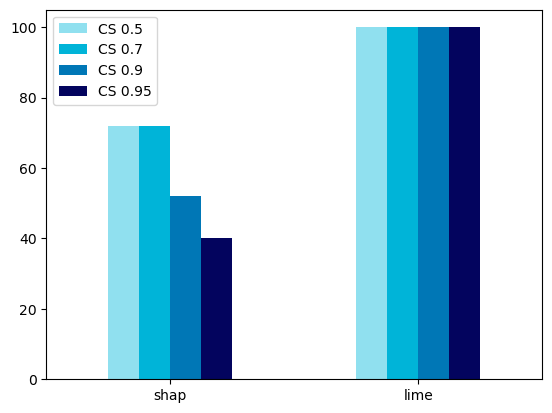

In [111]:
import pandas as pd

mpl.rcParams['axes.prop_cycle'] = cycler(color=['#90e0ef', '#00b4d8', '#0077b6', '#03045e'])

index = ['shap', 'lime']

df = pd.DataFrame({'CS 0.5': cs_results[0],'CS 0.7': cs_results[1],'CS 0.9': cs_results[2],'CS 0.95': cs_results[3]}, index=index)
ax = df.plot.bar(rot=0)